<a href="https://www.kaggle.com/code/maorsagi/face-recognition-2019?scriptVersionId=109725399" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [105]:
!pip install --upgrade git+https://github.com/goolig/dsClass.git
from dsClass.path_helper import *
import dsClass


  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-i5a805k9




  Running setup.py bdist_wheel for dsClass ... done

  Stored in directory: /tmp/pip-ephem-wheel-cache-9782tihj/wheels/c7/a9/03/023d8da4b4e004497715eeb1ea9b5d914ad425036bb4bc10b8

Successfully built dsClass


  Found existing installation: dsClass 1.0.27

    Uninstalling dsClass-1.0.27:

      Successfully uninstalled dsClass-1.0.27


You are using pip version 18.1, however version 19.3.1 is available.

You should consider upgrading via the 'pip install --upgrade pip' command.


In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [107]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['model-backup2', 'srgan-models-tutorial']


In [108]:
import os
cwd = os.getcwd()

from dsClass.align_custom import AlignCustom
from dsClass.face_feature import FaceFeature
from dsClass.mtcnn_detect import MTCNNDetect
from dsClass.tf_graph import FaceRecGraph
from dsClass.path_helper import *

import sys
import glob
import cv2
import json
import numpy as np
import pandas as pd
import time
import scipy
import urllib
import matplotlib.pyplot as plt

# Part 1 - Objective - Face Detection in Video

Detect and recognize the faces in the following youtube video:

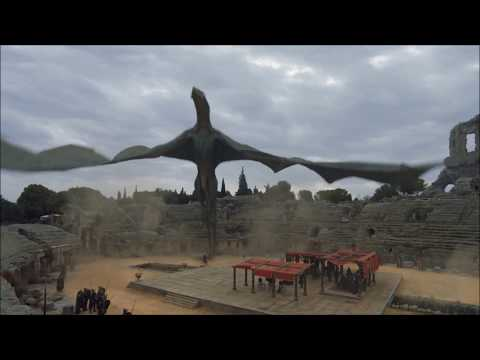

In [109]:
from IPython.display import YouTubeVideo
YouTubeVideo('NuhCoO6GO5U')

## Detection and Recgnition

Based and Inspired by:
- **https://github.com/vudung45/FaceRec
- Augmentation code: https://github.com/vxy10/ImageAugmentation
- Fancy borders: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/

Description:
- Images from Video Capture -> detect faces' regions -> crop those faces and align them 
- each cropped face is categorized in 3 types: Center, Left, Right 
- Extract 128D vectors( face features)
- Search for matching subjects in the dataset based on the types of face positions. 
- The preexisitng face 128D vector with the shortest distance to the 128D vector of the face on screen is most likely a match
(Distance threshold is 0.6, percentage threshold is 70%)
    

## Helper functions

In [110]:
def annotate_face(rect, recog_data, frame):
    """
    Draw a box around the face and label the person
    :param rect : the face bounding box
    :param recog_data : tuple of person name and confidence percentage
    :param frame : the frame to draw on
    """
    shrtname = short_name(recog_data[0])
    acc = round(recog_data[1], 1)
    bbox_color = (255, 255, 255) if "Unknown" in recog_data[0] else (124,252,0)  # RGB

    #draw bounding box / fancy border for the face
    #cv2.rectangle(frame,(rect[0],rect[1]),(rect[0] + rect[2],rect[1]+rect[3]),bbox_color) 
    draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), bbox_color, 1, 10, 10)  
    anot_text = shrtname + "-" + str(acc) + "%"
    cv2.putText(frame, anot_text,
                (rect[0]-4,rect[1]-4), cv2.FONT_HERSHEY_SIMPLEX,0.35,
                bbox_color, 1, cv2.LINE_AA)                        

    
def short_name(name):
    """e.g: Jaime Lannister -> Jaime.L"""
    if not name.startswith("Unknown"):
        name_split = name.split(" ")
        short_name = name_split[0]
        if len(name_split) > 1:
            short_name = short_name + "." + name_split[1][0]
        return(short_name)
    else:
        return name
    
    
def draw_border(img, pt1, pt2, color, thickness, r, d):
    """
    Fancy box drawing function by Dan Masek
    Code in: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/
    """
    x1, y1 = pt1
    x2, y2 = pt2
 
    # Top left drawing
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
 
    # Top right drawing
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
 
    # Bottom left drawing
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
 
    # Bottom right drawing
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness) 
    
    
def read_image_from_url(url2read):
    if url2read.startswith('http'):
        req = urllib.request.urlopen(url2read)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1) # 'Load it as it is'
    else:
        img = cv2.imread(url2read)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(img)

## Generate Face DB

In [111]:
dict_faces = dict()
dict_faces["Jaime Lannister"] = ["https://s2.r29static.com//bin/entry/97f/340x408,85/1832698/image.jpg",
                                "https://upload.wikimedia.org/wikipedia/en/thumb/b/b4/Jaime_Lannister-Nikolaj_Coster-Waldau.jpg/220px-Jaime_Lannister-Nikolaj_Coster-Waldau.jpg",
                                 "https://upload.wikimedia.org/wikipedia/pt/thumb/0/06/Nikolaj-Coster-Waldau-Game-of-Thrones.jpg/220px-Nikolaj-Coster-Waldau-Game-of-Thrones.jpg",
                                 "https://purewows3.imgix.net/images/articles/2017_09/jaime-lannister-season-7-game-of-thrones-finale1.jpg?auto=format,compress&cs=strip&fit=min&w=728&h=404",
                                 "https://cdn.newsday.com/polopoly_fs/1.13944684.1502107079!/httpImage/image.jpeg_gen/derivatives/landscape_768/image.jpeg",
                                 "https://www.cheatsheet.com/wp-content/uploads/2017/08/Jaime-Lannister-Game-of-Thrones.png",
                                 "https://fsmedia.imgix.net/9c/c0/27/10/15e0/44a4/8ecb/9339993b563d/nikolaj-coster-waldau-as-jaime-lannister-in-game-of-thrones-season-7.png?rect=0%2C0%2C1159%2C580&dpr=2&auto=format%2Ccompress&w=650",
                                 "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrIQuBKKUocAizwfWtIdhAcvfowLJatKqqDsO3ywYdh3rv-mBk"]
dict_faces["Cersei Lannister"] = ['https://cdn.pastemagazine.com/www/articles/CERSEI-LANNISTER-quotes-list.jpg',
                                 'https://assets3.thrillist.com/v1/image/2823203/size/gn-gift_guide_variable_c.jpg',
                                 'https://s3-us-west-2.amazonaws.com/flx-editorial-wordpress/wp-content/uploads/2017/07/13060545/Cersei-Lannister.jpg',
                                 'https://www.thewrap.com/wp-content/uploads/2018/07/cersei_lannister-1.jpg',
                                 'https://imagesvc.timeincapp.com/v3/fan/image?url=https%3A%2F%2Fwinteriscoming.net%2Ffiles%2F2018%2F09%2FCersei-Lannister.jpg&w=736&h=485&c=sc',
                                 'https://s1.r29static.com/bin/entry/b52/720x864,85/2180384/image.webp'
                                'https://img1.looper.com/img/gallery/the-worst-things-cersei-lannister-has-ever-done/intro-1557760232.jpg',
                                  "https://metro.co.uk/wp-content/uploads/2017/08/game-of-thrones-cersei-main-2.jpg?quality=90&strip=all&crop=0px%2C0px%2C720px%2C378px&resize=1200%2C630",
                       "https://api.time.com/wp-content/uploads/2019/02/game-of-thrones-season-8-photos-03.jpg",
                       "https://i0.wp.com/metro.co.uk/wp-content/uploads/2018/05/game-of-thrones-cersei-main-3.jpg?quality=90&strip=all&zoom=1&resize=644%2C429&ssl=1",
                       "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/cersei-euron-gift-1500579238.png?crop=0.563xw:1xh;center,top&resize=480:*",
                       "https://www.thewrap.com/wp-content/uploads/2018/07/cersei_lannister-1.jpg",
                       "https://cdn-www.konbini.com/en/files/2017/09/cersei-feat1.jpg",
                       "https://i.pinimg.com/originals/24/d1/fa/24d1fabf199c99f91435e2062a6d3926.jpg"]
dict_faces["Daenerys Targaryen"] = ["https://i.pinimg.com/originals/6c/5c/f5/6c5cf563639893ef3f22735e9d21550e.jpg",
                                   "https://i.pinimg.com/originals/d7/b3/24/d7b3241c1bc1a25c11cd95b4a4158b8e.jpg",
                                   "https://api.time.com/wp-content/uploads/2015/05/gameofthrones15_15.jpg?w=600&quality=85"]
dict_faces['Tyrion Lannister'] = ['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4Re6vnUjEBxywRkRLrCmTMLf4YMWUF19GYS3cbKuRzVoTCz1d&s',
                                  'https://www.hbo.com/content/dam/hbodata/series/game-of-thrones/character/s5/tyrion-lannister-1920.jpg/_jcr_content/renditions/cq5dam.web.1200.675.jpeg',
                                  'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/44ccdd999a4b20cdaef4696b8bf1a2c502db2b66f6909ae2a8a96a01a698370688e9b73dad75f0d33ea170c58a251155-1-1558322295.jpg?crop=0.668xw:1.00xh;0.0918xw,0&resize=480:*',
                                  'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/theory-1553634761.jpg?crop=0.501xw:1.00xh;0,0&resize=480:*',
                                  'https://fromheartopaper.files.wordpress.com/2019/09/picsart_09-11-02.35.13.png?w=1080',
                                  'https://upload.wikimedia.org/wikipedia/en/thumb/5/50/Tyrion_Lannister-Peter_Dinklage.jpg/220px-Tyrion_Lannister-Peter_Dinklage.jpg']
dict_faces['Euron Greyjoy'] = ['http://assets.viewers-guide.hbo.com/small597a20afe7893@2x.jpg',
                                'http://static1.squarespace.com/static/52fc05c9e4b08fc45bd99090/5331dfe2e4b0f77da2ddde51/5cd9bdc8cdc8f30001b28a0c/1557848897813/cq5dam.web.1280.1280.jpeg?format=1500w',
                                'https://vignette.wikia.nocookie.net/gameofthrones/images/f/fc/Euron-Profile.PNG/revision/latest?cb=20170916200257',
                                'https://images.radiox.co.uk/images/52162?crop=16_9&width=660&relax=1&signature=k6BDCtKEIBn0Vy8EeqjdLe_JpaI=',
                                'https://cdn.vox-cdn.com/thumbor/iGnjL2BCwm_o_iyLu40Y00IjU_s=/0x0:2560x1394/1200x0/filters:focal(0x0:2560x1394):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/16220189/Screen_Shot_2019_05_06_at_7.25.08_AM.png']
dict_faces['Qyburn'] = ['https://i.ytimg.com/vi/1Tsjj9o47n0/maxresdefault.jpg',
                        'https://i.redd.it/mm9sgp28ri811.jpg',
                        'https://vignette.wikia.nocookie.net/gameofthrones/images/2/2a/Qyburn_3x01.jpg/revision/latest/top-crop/width/300/height/300?cb=20130502025950',
                        'https://vignette.wikia.nocookie.net/gameofthrones/images/8/8a/804_Qyburn_Profile.png/revision/latest?cb=20190508024406']
dict_faces['Jon Snow'] = ['https://www.esquireme.com/sites/default/files/styles/full_img/public/images/2019/05/20/Game-of-Thrones-Season-8-Ep-6-Finale-%284%29.png?itok=1LN_Lkkk',
                        'https://images2.minutemediacdn.com/image/upload/c_crop,h_840,w_1500,x_0,y_6/f_auto,q_auto,w_1100/v1555003564/shape/mentalfloss/jon_snow_hed.jpg',
                        'https://d.newsweek.com/en/full/507446/jon-snow-game-thrones.jpg',
                        'https://www.indiewire.com/wp-content/uploads/2019/04/Helen-Sloan-HBO-4-copy.jpg?w=780',
                        'https://cdn.vox-cdn.com/thumbor/o2AXRjdoyonKroOEsxQjYWvtG-U=/99x0:1179x810/1200x800/filters:focal(99x0:1179x810)/cdn.vox-cdn.com/uploads/chorus_image/image/46094226/Jon_snow.0.jpg',
                        'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/jon-snow-rhaegar-targaryen-1554321615.jpg?crop=0.482xw:0.962xh;0,0&resize=480:*',
                        'https://image.insider.com/5cb3c8e96afbee373d4f2b62?width=1100&format=jpeg&auto=webp',
                        'https://vignette.wikia.nocookie.net/gameofthrones/images/d/d0/JonSnow8x06.PNG/revision/latest?cb=20190714094440']


'dict_faces["Cersei Lannister"] = [\'https://cdn.pastemagazine.com/www/articles/CERSEI-LANNISTER-quotes-list.jpg\',\n                                 \'https://assets3.thrillist.com/v1/image/2823203/size/gn-gift_guide_variable_c.jpg\',\n                                 \'https://s3-us-west-2.amazonaws.com/flx-editorial-wordpress/wp-content/uploads/2017/07/13060545/Cersei-Lannister.jpg\',\n                                 \'https://www.thewrap.com/wp-content/uploads/2018/07/cersei_lannister-1.jpg\',\n                                 \'https://imagesvc.timeincapp.com/v3/fan/image?url=https%3A%2F%2Fwinteriscoming.net%2Ffiles%2F2018%2F09%2FCersei-Lannister.jpg&w=736&h=485&c=sc\',\n                                 \'https://s1.r29static.com/bin/entry/b52/720x864,85/2180384/image.webp\'\n                                \'https://img1.looper.com/img/gallery/the-worst-things-cersei-lannister-has-ever-done/intro-1557760232.jpg\',\n                                  "https://metro.co.uk/wp-conten

Checking: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrIQuBKKUocAizwfWtIdhAcvfowLJatKqqDsO3ywYdh3rv                                                                                                     

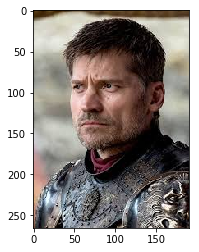

In [112]:
# Check urls and print last image
# if any image causes problems (like error 403 forbidden) then remove it and choose another
for p in dict_faces.keys():
    urls = dict_faces[p]
    for url2read in urls:
        print('\rChecking: %s' % url2read[:100], ' '*100, end='')
        img = read_image_from_url(url2read)
plt.imshow(img);

## Detect Faces Using Haar Cascades

In [113]:
os.chdir("/kaggle/working/")
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
!ls

--2020-01-10 11:06:07--  https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml

Resolving github.com (github.com)... 140.82.114.4

Connecting to github.com (github.com)|140.82.114.4|:443... connected.

HTTP request sent, awaiting response... 302 Found

Location: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml [following]

--2020-01-10 11:06:08--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...

Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 930127 (908K) [text/plain]

Saving to: ‘haarcascade_frontalface_default.xml.3’



haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.08s

In [114]:
#Create the haar cascade
face_cascade = cv2.CascadeClassifier('/kaggle/working/haarcascade_frontalface_default.xml')  # if not running on kaggle, remove the initial '/'

def find_faces_in_image(orig_img, scaleFactor, minNeighbors, minSize, maxSize):
    orig_img_copy = orig_img.copy()
    gray = cv2.cvtColor(orig_img_copy, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray) 
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(
        gray,           
        scaleFactor=scaleFactor, 
        minNeighbors=minNeighbors,  
        minSize=minSize, 
        maxSize=maxSize 
    )
    
    print("Found {0} faces!".format(len(faces)))

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(orig_img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    return faces
    plt.imshow(orig_img_copy)

In [115]:
img =read_image_from_url('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg')
scaleFactor = 1.1
minNeighbors = 3
minSize = (100, 100)   
maxSize = (600, 600)
find_faces_in_image(img, scaleFactor, minNeighbors, minSize, maxSize)

Found 4 faces!


array([[ 906,  150,  208,  208],
       [1508,  320,  168,  168],
       [ 606,  321,  199,  199],
       [ 269,  304,  179,  179]], dtype=int32)

### Mini Assignemnt
Change paramaters of (scaleFactor, minNeighbors, minSize, maxSize) above to find all faces in the GOT image,
use information in: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html

## Face Detection in Video using Haar

### Mini assignment
Complete the following find_faces_in_frame_of_video() function so we can do face detection on the video

In [116]:
def find_faces_in_frame_of_video(frame, scaleFactor, minNeighbors, minSize, maxSize):
    """Find faces in an image and returns the bounding boxes of them"""
    return find_faces_in_image(frame, scaleFactor, minNeighbors, minSize, maxSize)

In [117]:
def video_file_recog_haar(src_filename, output_filename='/kaggle/working/output_haar.mp4', framerate=None, scaleFactor=1.3, minNeighbors=6, minSize=35, maxSize=200):
    print("[INFO] Reading video file...")
    if glob.glob(src_filename):
        vs = cv2.VideoCapture(src_filename); #get input from file
    else:
        print("file does not exist")
        return
    
    print("[INFO] Initializing video writer...")
    frame_width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # DIVX, XVID, MJPG, X264, WMV1, WMV2, mp4v
    if framerate is None:
        framerate = vs.get(cv2.CAP_PROP_FPS) # use same as input video, or can set to 20.0 / 30.0
    out = cv2.VideoWriter(output_filename, fourcc, framerate, (frame_width,frame_height))
    
    recog_list = []
    frame_counter = 0
    t0 = time.time()
    while True:        
        ret, frame = vs.read();
        if ret:
            frame_counter += 1
            if frame_counter%(30/framerate)==0:
                min_face_size = 60 #min face size is set to 60x60
                rects = find_faces_in_frame_of_video(frame, scaleFactor, minNeighbors, (minSize, minSize), (maxSize,maxSize))
                print("\rNumber of faces found in frame " + str(frame_counter) + ":",len(rects), end='')
                aligns = []
                positions = []
                for (i, rect) in enumerate(rects):
                    draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (255,255,255), 1, 10, 10)
                    cv2.putText(frame,"Unknown",
                                        (rect[0]-4,rect[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.35,
                                        (255,255,255),1,cv2.LINE_AA)


                out.write(frame)
        else:  # end of video, no more frames
            break
    
    elapsed_time = time.time() - t0
    print()
    print("[exp msg] elapsed time for going over the video: " + str(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    vs.release()
    out.release()
    cv2.destroyAllWindows()
    print("Done")

In [118]:
video_file_recog_haar(src_filename = get_file_path("Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4"), framerate=10)

[INFO] Reading video file...

[INFO] Initializing video writer...

Found 0 faces!

Number of faces found in frame 3: 0Found 0 faces!

Number of faces found in frame 6: 0Found 0 faces!

Number of faces found in frame 9: 0Found 1 faces!

Number of faces found in frame 12: 1Found 1 faces!

Number of faces found in frame 15: 1Found 1 faces!

Number of faces found in frame 18: 1Found 1 faces!

Number of faces found in frame 21: 1Found 1 faces!

Number of faces found in frame 24: 1Found 1 faces!

Number of faces found in frame 27: 1Found 1 faces!

Number of faces found in frame 30: 1Found 1 faces!

Number of faces found in frame 33: 1Found 1 faces!

Number of faces found in frame 36: 1Found 1 faces!

Number of faces found in frame 39: 1Found 1 faces!

Number of faces found in frame 42: 1Found 1 faces!

Number of faces found in frame 45: 1Found 1 faces!

Number of faces found in frame 48: 1Found 1 faces!

Number of faces found in frame 51: 1Found 1 faces!

Number of faces found in frame 54: 1

## Detect Faces Using MTCNN

In [119]:
#Global Variables
person_embeddings = None

### Generate Faces DB functions
- Extract and crop faces from each given image
- convert faces to embedded vector of 128D

In [120]:
def augment_image(img):
    """Takes an image array and returns a list of its augemented versions"""
    aug_images = []
    #https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=flip#cv2.flip
    # for more examples see https://github.com/aleju/imgaug
    return(aug_images)


def get_person_imgs(urls, min_face_size=40):
    """
    Given a list of URLs of a person images, this function will extract and align the faces within the image and detect its pose (left/right/center)
    """
    person_imgs = {"Left" : [], "Right": [], "Center": []};
    person_imgs_count = {"Left" : 0, "Right": 0, "Center": 0};
    
    counter_break = 0
    while True:    
        for url2read in urls:
            #print(file)
            #ret, frame = vs.read()
            #img = cv2.imread(file)
            img = read_image_from_url(url2read) # ****** file = url2read
            if img is None:
                print("********************* image was not loaded ***********************")
                continue

            # Augmenting the data - add a flipped version of the image to add more data
            frames = [img]
            frames.extend(augment_image(img))

            for frame in frames:
                if True: #ret:
                    rects, landmarks = face_detect.detect_face(frame, min_face_size)
                    #print("rects", rects)
                    for (i, rect) in enumerate(rects):
                        aligned_frame, pos = aligner.align(160, frame,landmarks[i]);
                        #print(pos)
                        person_imgs_count[pos]+=1
                        if len(aligned_frame) == 160 and len(aligned_frame[0]) == 160:
                            person_imgs[pos].append(aligned_frame)
                            #cv2.imshow("Captured face", aligned_frame)
                            #cv2.imwrite("../data2/frame%d.jpg" % count, aligned_frame)
                else:
                    break
            
        if person_imgs_count["Left"] == 0 or person_imgs_count["Right"] == 0 or person_imgs_count["Center"] == 0:
            counter_break+=1
            if counter_break > 0:
                print(person_imgs_count) 
                assert 0==1, "Must get all poses of a face: Left, Right and Center, try adding more images"
                return None
        else:
            break
                            
    print(person_imgs_count)    
    return(person_imgs)  

In [121]:
def extract_embeddings_from_images(min_face_size=40, embeddings_filename='/kaggle/working/facerec_128D.txt'):
    """ 
    Go over all urls, extract and align faces, feed each face to the embeddings net,
    and saves an embedding vector for each person-position pair.
    Save all embeddings to a .txt file
    """
    print()
    print("[INFO] Extracting data from images ...")
    data_set = dict()

    for new_name in dict_faces.keys():
        person_features = {"Left" : [], "Right": [], "Center": []};
        print("Extracting:", new_name)
        print("number of img files:",len(dict_faces[new_name]))
        person_imgs = get_person_imgs(dict_faces[new_name], min_face_size=min_face_size) 
        if person_imgs is None:
            print("extraction of:",new_name, " failed")
            continue
        
        print("extracted person_imgs from:",new_name)
        print("-------------------------------------")

        for pos in person_imgs: # there are some exceptions here, but I'll just leave it as this to keep it simple
            person_features[pos] = [np.mean(extract_feature.get_features(person_imgs[pos]), axis=0).tolist()]
        data_set[new_name] = person_features;
    
    global person_embeddings
    person_embeddings = data_set
    with open(embeddings_filename, 'w+') as f:
        f.write(json.dumps(data_set))
    

def load_embeddings_from_file(embeddings_filename='/kaggle/working/facerec_128D.txt'):
    global person_embeddings
    with open(embeddings_filename, 'r') as f:
        person_embeddings = json.loads(f.read());

        
def identifyPerson(features_arr, position, thres = 0.6, percent_thres = 70):
    '''
    :param features_arr: a list of 128d Features of a face
    :param position: face position types (Left/Right/Center)
    :param thres: distance threshold
    :param percent_thres : minimum confidence required to identify a person
    :return: tuple of person name and confidence of detection
    '''
    assert person_embeddings is not None, "Must load or extract persons embeddings in order to recgonize persons"
    result = "Unknown"
    smallest = sys.maxsize  # initialize with a large number
    for person in person_embeddings.keys():
        person_data = person_embeddings[person][position]
        for data in person_data:  # in our case there's only one embedding per person-position pair
            distance = scipy.spatial.distance.euclidean(data, features_arr)  # same as: np.sqrt(np.sum(np.square(data-features_arr)))
            #distance = scipy.spatial.distance.cosine(data, features_arr)  # if using cosine distance it is recommended to lower the thres to ~0.4
            
            if(distance < smallest):
                smallest = distance
                result = person
    percentage =  min(100, 100 * thres / smallest)
    if percentage <= percent_thres:
        result = "Unknown (%s)" % result.split(' ')[0]  # show highest score person for debug purposes
    return (result, percentage)

### Initialize

In [122]:
!ls

__notebook_source__.ipynb	       haarcascade_frontalface_default.xml.2

facerec_128D.txt		       haarcascade_frontalface_default.xml.3

haarcascade_frontalface_default.xml    output.mp4

haarcascade_frontalface_default.xml.1  output_haar.mp4


In [123]:
model_path = '../input/model-backup2/model-20170512-110547.ckpt-250000' 
os.chdir("/kaggle/input/")  # if not on kaggle environment then omit the initial '/'

In [124]:
# initalize
FRGraph = FaceRecGraph();
aligner = AlignCustom();
extract_feature = FaceFeature(FRGraph, model_path = model_path);
face_detect = MTCNNDetect(FRGraph, scale_factor=2); #scale_factor, rescales image for faster detection

Loading model...

Model loaded

Loading MTCNN Face detection model

MTCNN Model loaded


### Generate face database

In [125]:
#load_embeddings_from_file()
extract_embeddings_from_images(min_face_size=40)



[INFO] Extracting data from images ...

Extracting: Jaime Lannister

number of img files: 8

{'Left': 3, 'Right': 2, 'Center': 4}

extracted person_imgs from: Jaime Lannister

-------------------------------------


## Part by Part Walkthrough

### Face Detection

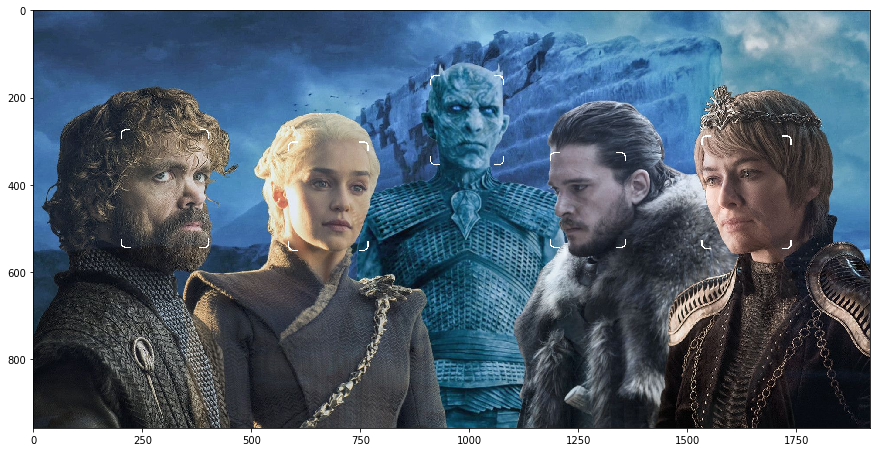

In [126]:
url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg'
frame = read_image_from_url(url)
rects, landmarks = face_detect.detect_face(frame, minsize=40);  # min face size is set to 80x80

for rect in rects:
    draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (255,255,255), 2, 10, 10)
    
plt.subplots(figsize=(15,10))
plt.imshow(frame);

### Landmarks

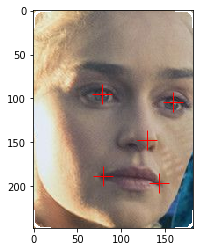

In [127]:
idx = 0
rect = rects[idx]
plt.imshow(frame[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
for k in range(int(len(landmarks[idx]) / 2)):
    plt.plot(landmarks[idx][k]-rect[0], landmarks[idx][k+5]-rect[1], 'r+', markersize=20)

### Align Face

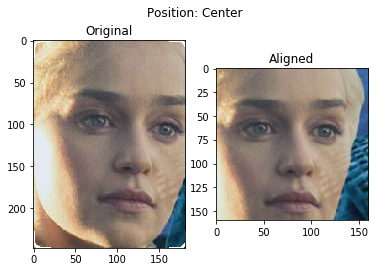

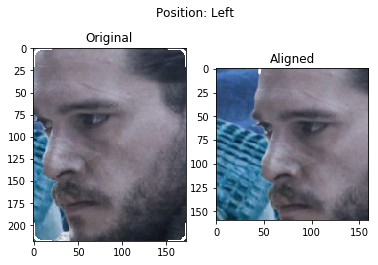

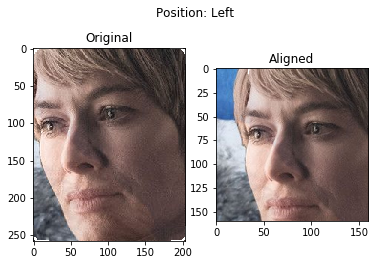

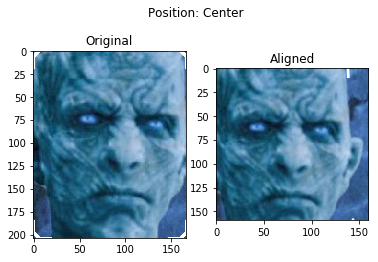

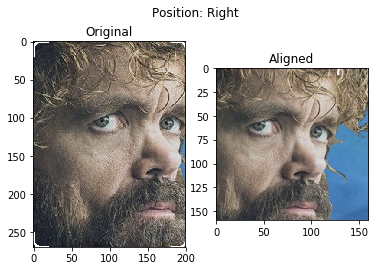

In [128]:
for (i, rect) in enumerate(rects):
    aligned_frame, pos = aligner.align(160, frame, landmarks[i])
    plt.subplot(121)
    plt.imshow(frame[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(aligned_frame)
    plt.title('Aligned')
    plt.suptitle('Position: %s' % pos)
    plt.show()

### Feature extraction

In [129]:
features_vector = extract_feature.get_features([aligned_frame])

In [130]:
features_vector.shape

(1, 128)

In [131]:
features_vector

array([[ 3.11142672e-02,  2.46980526e-02,  3.29918228e-02,
         5.08028083e-02,  1.15072891e-01, -7.94819519e-02,
        -1.28052747e-02,  5.89794479e-03,  6.34307712e-02,
         9.14914683e-02, -2.76530869e-02,  8.77600312e-02,
         1.37535065e-01, -3.87124196e-02, -1.00775540e-01,
        -7.19313137e-03,  2.92396378e-02, -6.98603913e-02,
         3.51812840e-02,  1.43233255e-01,  1.16712756e-01,
         5.53063750e-02,  3.00946534e-02,  5.22615500e-02,
         4.52990942e-02, -5.80481291e-02, -3.97106633e-02,
         3.60590592e-02, -1.49504589e-02,  5.54326475e-02,
         8.48229453e-02, -7.16805905e-02, -7.96229753e-04,
        -6.04001358e-02,  1.23262126e-02, -1.13809638e-01,
        -2.83308960e-02, -3.28637585e-02, -1.93342082e-02,
         9.59009007e-02, -5.79381585e-02,  7.85025433e-02,
        -4.69629280e-02,  1.00079872e-01, -4.43182699e-02,
         5.39847240e-02, -2.21071523e-02,  5.01039065e-02,
        -8.19348171e-02,  1.25337973e-01, -1.49131238e-0

## Face Recognition in Video using MTCNN, aligner and embedded vectors

### Mini assignment
Complete the following frame_face_recog() function so we can do face detection on the video

In [132]:
def frame_face_recog(frame, min_face_size=80, percent_thres = 70, verbose=False):
    """ 
    Detect faces in a frame, try to recgonize them, and draws a box around the face with predicted person + % confidence
    :param frame : the frame to indentify faces in. an array with shape of width X height X channels
    :param min_face_size : minimum size of face to detect. integer. e.g: value of 80 is set to 80x80 pixels
    :param verbose : True to print debug information while running
    
    Alters inplace the frame with predictions annotations
    returns a list of (person,confidence) tuples
    """
    aligner_resize_to = 160  # the aligner function will rescale image to X by X pixels before sent to be embedded.
    
    # Detect all faces in frame and get their bounding-rectangles and landmarks
    # <your code here>
    
    # Go through each face in frame and perform:
    #  1) align the face (using aligner.align() function). remember that aligner.align() returns the aligned-face and face-pose (left/right/center)
    #  2) extract aligned face features (embeddings)
    #  3) find the person the face belongs to
    #  4) draw a box around the face and label the person
    recog_list = []
    # <your code here>
    
    rects, landmarks = face_detect.detect_face(frame, minsize=40);  # min face size is set to 80x80
    for (i, rect) in enumerate(rects):
        aligned_frame, pos = aligner.align(160, frame, landmarks[i])
        features_vector = extract_feature.get_features([aligned_frame])
        recog_data = identifyPerson(features_vector,pos, percent_thres = percent_thres)
        recog_list.append(recog_data)
        if verbose : print ("recog_data", str(recog_data))
        annotate_face(rect, recog_data, frame)
    return recog_list

### test your function

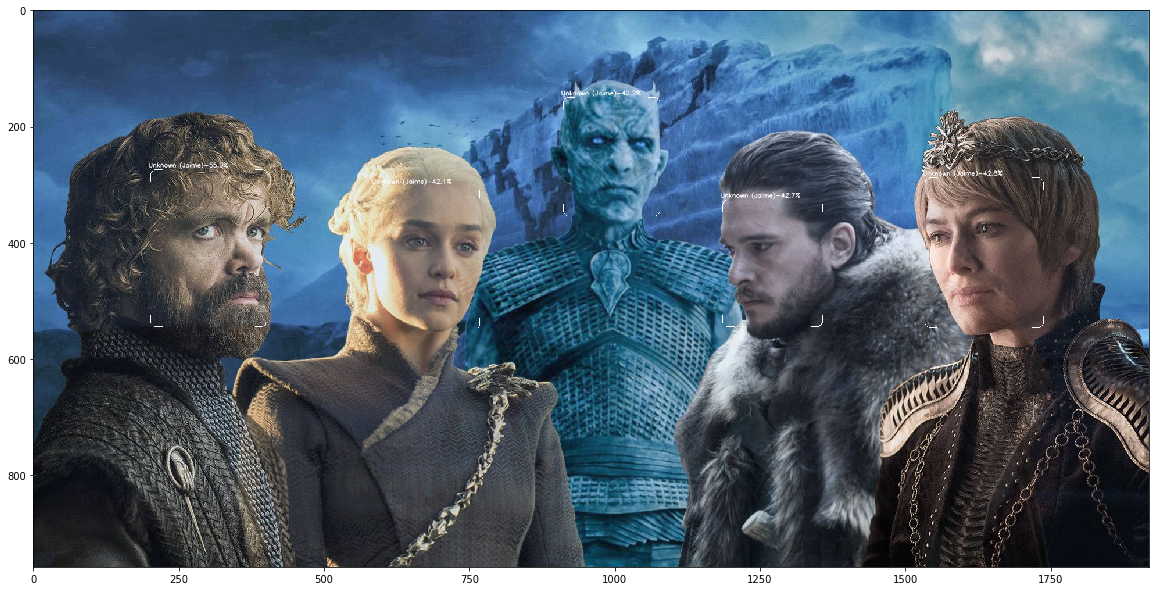

In [133]:
url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg'
frame = read_image_from_url(url)
frame_face_recog(frame)
plt.subplots(figsize=(20,15))
plt.imshow(frame);

In [134]:
def video_file_recog(src_filename, output_filename='/kaggle/working/output.mp4', percent_thres = 70, verbose=False):
    print("[INFO] Reading video file...")
    if glob.glob(src_filename):
        vs = cv2.VideoCapture(src_filename); #get input from file
    else:
        print("file does not exist")
        return
    
    print("[INFO] Initializing video writer...")
    frame_width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # DIVX, XVID, MJPG, X264, WMV1, WMV2, mp4v
    framerate = vs.get(cv2.CAP_PROP_FPS) # use same as input video, or can set to 20.0 / 30.0
    out = cv2.VideoWriter(output_filename, fourcc, framerate, (frame_width,frame_height))
    
    recog_list = []
    frame_counter = 0
    t0 = time.time()
    while True:        
        ret, frame = vs.read();
        if ret:
            frame_counter += 1
            print('\rProcessing Frame %i/%i' % (frame_counter, total_frames), end=' ')
            recog_data = frame_face_recog(frame, min_face_size=40, percent_thres=percent_thres, verbose=verbose)
            recog_list.extend(recog_data)
            #cv2.imshow("Frame",frame)
            #cv2.imwrite("../data3/frame%d.jpg" % count, frame)
            out.write(frame)
        else:  # end of video, no more frames
            break
    
    elapsed_time = time.time() - t0
    print()
    print("[exp msg] elapsed time for going over the video: " + str(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    vs.release()
    out.release()
    cv2.destroyAllWindows()
    
    known_counter = len([1 for recog in recog_list if recog[1] > percent_thres])
    unknown_counter = len(recog_list) - known_counter
    print("known_counter:", known_counter, "unknown_counter:", unknown_counter)
    
    print()
    print("Done")

### RUN Video generation

In [135]:
video_file_recog(src_filename = get_file_path("Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4"), percent_thres=70, verbose=False)

[INFO] Reading video file...

[INFO] Initializing video writer...

Processing Frame 3297/3297 

[exp msg] elapsed time for going over the video: 00:02:48

known_counter: 62 unknown_counter: 1027



Done


In [136]:
# the output file from opencv is just video frames (Without audio). lets add the original audio track to the output movie
# if ffmpeg is not installed then it will return False
#vid2vid_audio_transfer('Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4', 'output.mp4', 'output_w_audio.mp4');

In [137]:
!ls ../working/ -ashl

total 29M

4.0K drwxr-xr-x 3 root root 4.0K Jan 10 11:06 .

4.0K drwxr-xr-x 6 root root 4.0K Jan 10 10:37 ..

4.0K drwxr-xr-x 2 root root 4.0K Jan 10 10:37 .ipynb_checkpoints

4.0K -rw-r--r-- 1 root root  199 Jan 10 10:37 __notebook_source__.ipynb

 12K -rw-r--r-- 1 root root 8.3K Jan 10 11:06 facerec_128D.txt

916K -rw-r--r-- 1 root root 909K Jan 10 10:39 haarcascade_frontalface_default.xml

916K -rw-r--r-- 1 root root 909K Jan 10 10:53 haarcascade_frontalface_default.xml.1

916K -rw-r--r-- 1 root root 909K Jan 10 11:01 haarcascade_frontalface_default.xml.2

916K -rw-r--r-- 1 root root 909K Jan 10 11:06 haarcascade_frontalface_default.xml.3

 17M -rw-r--r-- 1 root root  17M Jan 10 11:09 output.mp4

8.5M -rw-r--r-- 1 root root 8.4M Jan 10 11:06 output_haar.mp4


## Questions and Instructions - Part 1

### Haar Cascade
- Change paramaters of (scaleFactor, minNeighbors, minSize, maxSize) to find all faces in the GOT image, using find_faces_in_image().
    - gray is the input grayscale image.
    - scaleFactor is the parameter specifying how much the image size is reduced at each image scale. It is used to create the scale pyramid.
    - minNeighbors is a parameter specifying how many neighbors each candidate rectangle should have, to retain it. A higher number gives 
      lower false   positives.
    - minSize is the minimum rectangle size to be considered a face.
    - More help can be found in: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html
- Which parameters did the best work?
- complete function find_faces_in_frame_of_video() to run face detection using  video_file_recog_haar() on the GOT video
-  Change paramaters of (scaleFactor, minNeighbors, minSize, maxSize) to find as many TRUE faces as possible in video using
    video_file_recog_haar()
    - To download output video file (output_haar.mp4): click on the download icon near its name in the right pane. click once and wait, as sometimes it takes it a bit of time to process the download.
    - Which parameters did the best work?
- Check your parameters with framerate of 30 when you think it is good enough

### MTCNN and Face Vector Search
- RUN Network Based Detection and Recognition code
- Download movie output.mp4 and check who was recognized and how many times?
- Add more individulas to the database so you could recgnize more individuals in video (notice you need images with center, right, left angles)
- What led you to choose the images you chose? what was your thought process?
- Try to augment the images using the augment_image function, does that improves the accuracy?
   - For help check opencv image manipulaions and https://github.com/aleju/imgaug
- Try to change min_face_size and see if you can recgnize faces in more frames
- How would you increase the accuracy of the recognition?
- How would you increase the consistency of the recognition (like when the same face is recognized in one frame and not in the next)?
- How would you make the entire process run faster?
- what will happen if we will reshape the face images (that the aligner returns) to something other than 160x160 pixels?
- what should you do if you want to methodically test your model on the given video file?
- in second 55, Cersei isn't recognized well? which images you should include in person-images to improve that?